In [ ]:
!wget -q https://raw.githubusercontent.com/openforcefield/2023-workshop-vignettes/main/colab_setup.ipynb
%run colab_setup.ipynb
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
!mamba install "openff-nagl-models =0.0.2" "openff-nagl = 0.2.2" -c conda-forge -yq

# Custom substructure loading from PDB and NAGL charge assignment

This is a RED example showcasing early prototypes of functionality that we plan to make available in the coming year. We provide no guarantee of stability or correct operation, but this is an example of what may be to come.

This example will:
* Load a modified protein from PDB using `Topology.from_pdb`
* Create a librarycharge for just the modified residue and create the OpenMM system with ff14SB parameters

See also:
https://gist.github.com/Yoshanuikabundi/66007cb9966b1455a259baaf7cd7e7c3#file-ncaa_parametrization-ipynb

## Introduction

Here we have a PDB structure containing a protein with sequence "ACE-THR(mod)-GLY-NME". The threonine is modified with a PO4, which is further modified with a CNCO moiety (this modified residue almost certainly doesn't have a existing residue code, so I'm using it in this example to emphasize that this functionality can load totally arbitrary residues)

In [1]:
import openmm
import openmm.unit as omm_unit
from openmm.app import DCDReporter
import numpy as np
import mdtraj
import nglview
import rdkit.Chem
from chemper.mol_toolkits import mol_toolkit
from chemper.graphs.single_graph import SingleGraph
from pdbfixer import PDBFixer

from openff.units import unit
from openff.units.openmm import from_openmm

from openff.toolkit import Molecule, ForceField
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler
import openff.toolkit.utils.exceptions

In [2]:
import nglview

w = nglview.show_file("inputs/ace-ZZZ-gly-nme.pdb")
w.clear_representations()
w.add_representation("licorice")
w

NGLWidget()

## (New) Requirements for `Topology.from_pdb`


We're using OpenMM's PDBFile class under the hood for the initial loading. This leads to the following requirements in the input PDB:

* Standard residues must have canonical residue and atom names
* Modified residues must have elements explicitly listed in the last column
* The connectivity (but not bond order) of the modified residue must be explicitly specified using CONECT records (including peptide bonds to adjacent residues)

In [3]:
!cat inputs/ace-ZZZ-gly-nme.pdb

REMARK   1 CREATED WITH OPENMM 8.0, 2023-04-25
ATOM      1  C   ACE A   1      -2.066  -2.592   0.175  1.00  0.00           C
ATOM      2  CH3 ACE A   1      -2.551  -3.997   0.367  1.00  0.00           C
ATOM      3  O   ACE A   1      -2.742  -1.857  -0.621  1.00  0.00           O
ATOM      4  H1  ACE A   1      -3.605  -4.130   0.022  1.00  0.00           H
ATOM      5  H2  ACE A   1      -1.889  -4.674  -0.185  1.00  0.00           H
ATOM      6  H3  ACE A   1      -2.443  -4.229   1.460  1.00  0.00           H
HETATM    7  C3x ZZZ A   2       0.958  -0.804   0.130  1.00  0.00           C  
HETATM    8  O2x ZZZ A   2       1.422   0.410  -0.180  1.00  0.00           O  
HETATM    9  P1x ZZZ A   2       2.782   0.984   0.562  1.00  0.00           P  
HETATM   10  O3x ZZZ A   2       3.223   2.281  -0.117  1.00  0.00           O  
HETATM   11  O4x ZZZ A   2       4.036  -0.203   0.428  1.00  0.00           O  
HETATM   12  C4x ZZZ A   2       5.229   0.481   0.703  1.00  0.00        

Let's get started on the workflow by making a representation of the non-canonical amino acid, which we'll use to teach our PDB loader about the new substructure. I'm labeling the connection points with [Li] atoms.

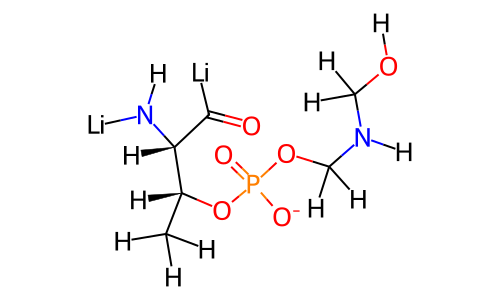

In [4]:
from openff.toolkit import Molecule, Topology

# Make unnatural AA as its own mol. Since a residue is a substructure, not a valid molecule,
# use something that's easy to recognize as a "cap". Here I use Li since it makes one bond and
# we're super unlikely to see Li anywhere else.
substructure_mol = Molecule.from_smiles(
    "[Li]N[C@@H]([C@@H](C)O[P@](=O)(OCNCO)[O-])C(=O)[Li]"
)
substructure_mol

In [5]:
# Label the atoms with whether they're leaving
for atom in substructure_mol.atoms:
    if atom.symbol == "Li":
        atom.metadata["substructure_atom"] = False
    else:
        atom.metadata["substructure_atom"] = True

In [6]:
fixer = PDBFixer("inputs/ace-ZZZ-gly-nme.pdb")
fixer.addSolvent(
    padding=1.0 * omm_unit.nanometer, ionicStrength=0.15 * omm_unit.molar
)

with open("peptide_solvated.pdb", "w") as f:
    openmm.app.PDBFile.writeFile(fixer.topology, fixer.positions, f)

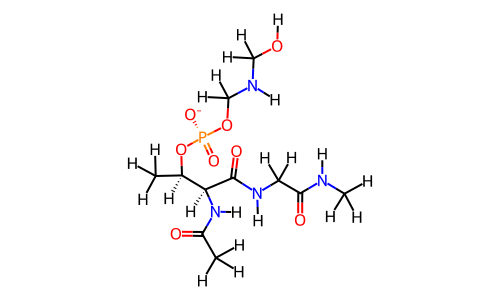

In [7]:
top = Topology.from_pdb(
    "peptide_solvated.pdb",
    # _additional_substructures is a PROTOTYPE.
    # Its behavior and input type are likely to change.
    _additional_substructures=[substructure_mol],
)

# And it's loaded!
mol = top.molecule(0)
mol.visualize(backend="rdkit")

## (Old) 
Now let's extract the unnatural residue in a form suitable for library charge creation.

In [8]:
sage_ff14sb = ForceField("openff-2.0.0.offxml", "ff14sb_off_impropers_0.0.3.offxml")

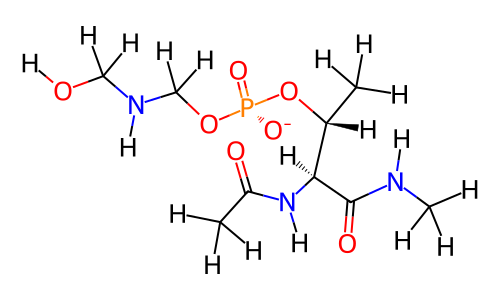

In [9]:
def find_and_cap_residue(molecule, resname, allow_undefined_stereo=False):
    """
    Find the first residue with resname and extract and cap it
    """
    import rdkit

    rdmol = molecule.to_rdkit()

    rxn = rdkit.Chem.rdChemReactions.ReactionFromSmarts(
        "[C](=[O])[N:3]([H:4])[C:5][C:6](=[O:7])[N]"
        + " >> "
        + "[CH3]C(=O)[N:3]([H:4])[C:5][C:6](=[O:7])N([H])[CH3]"
    )
    products = rxn.RunReactants([rdmol])

    for product in products:
        capped_aa = product[0]
        for atom in capped_aa.GetAtoms():
            res = atom.GetPDBResidueInfo()
            if res is None:
                continue
            if res.GetResidueName() == resname:
                capped_ncaa = capped_aa
                chain_id = res.GetChainId()
                residue_number = res.GetResidueNumber()
                break

    rdkit.Chem.SanitizeMol(capped_ncaa)

    offmol = Molecule.from_rdkit(
        capped_ncaa, allow_undefined_stereo=allow_undefined_stereo
    )
    offmol.generate_conformers()

    for cap_resname, smarts, resoffset in [
        ("ACE", "[C:1]([H:2])([H:3])([H:4])[C:5](=[O:6])N", -1),
        ("NME", "[C:1]([H:2])([H:3])([H:4])[N:5]([H:6])C", +1),
    ]:
        matches = offmol.chemical_environment_matches(smarts, unique=True)
        for match in matches:
            for idx in match:
                atom = offmol.atom(idx)
                if atom.metadata.get("residue_name") is None:
                    atom.metadata["residue_name"] = cap_resname
                    atom.metadata["residue_number"] = residue_number + resoffset
                    atom.metadata["insertion_code"] = " "
                    atom.metadata["chain_id"] = chain_id
    offmol.add_default_hierarchy_schemes()

    return offmol


ncaa_capped = find_and_cap_residue(mol, "ZZZ", allow_undefined_stereo=True)
ncaa_capped.visualize()

In [10]:
# Temporary fix for an RDKit/OpenEye stereochemistry spat
for atom in ncaa_capped.atoms:
    if atom.symbol == "P":
        atom._stereochemistry = None

## (Old) Assign partial charges using OE if available, RDKit otherwise

In [11]:
%%time
try:
    ncaa_capped.assign_partial_charges("am1bccelf10")
    print("Using OpenEye AM1BCC ELF10 charges")

except:
    ncaa_capped.assign_partial_charges("am1bcc")
    print("Using AmberTools single-conformer AM1BCC charges")
reference_charges = ncaa_capped.partial_charges
print(reference_charges)

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 15, name: P1x, idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: O2x, idx: 13, aromatic: False, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: O3x, idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: O4x, idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: O6x, idx: 22, aromatic: False, chiral: False



Using OpenEye AM1BCC ELF10 charges
[-0.17298998951147765 0.6635299968795899 -0.6449699950141784 -0.5363299798889037 0.34175000072289735 0.030680005558026142 0.6511800336914185 -0.605220015041339 -0.5761700224799987 0.3062399971561554 0.08707000792790683 0.20031001151372224 0.07558000565339358 -0.5779600095672485 0.07348000735808642 -0.1195399936957237 1.436669950492871 0.037830003656637974 0.037830003656637974 0.037830003656637974 -0.8180500221176025 -0.5694500160140868 -0.8180500221176025 0.42407000542451173 -0.8837900113983032 0.02717000537384779 0.02717000537384779 0.3757199990825775 0.36476001621056825 -0.6220300149841186 0.03426000580955774 0.03426000580955774 0.3977699923591736 0.05872000486422808 0.05872000486422808 0.05872000486422808 0.03441000462342531 0.03441000462342531 0.03441000462342531] elementary_charge
CPU times: user 13.5 s, sys: 133 ms, total: 13.6 s
Wall time: 13.9 s


## (New) Or use the NAGL prototype to assign charges

NAGL takes a few seconds to load in two cases:
* The first time it's run in a new conda environment (arcane machine learning stuff getting compiled)
* When it's first imported and used in a script



After that, assigning partial charges is very quick

(Also keep in mind that this is an early prototype - The current implementation sometimes doesn't like being run multiple times in one session. If you start getting weird errors, try restarting the notebook)

In [12]:
from openff.toolkit.utils._nagl_wrapper import _NAGLToolkitWrapper

# Do a "sacrificial" first run of nagl on methane so the model is compiled in this cell
Molecule.from_smiles("C").assign_partial_charges(
    "_nagl_am1bccelf10", toolkit_registry=_NAGLToolkitWrapper()
)

In [13]:
%%time
ncaa_capped.assign_partial_charges(
    "_nagl_am1bccelf10", toolkit_registry=_NAGLToolkitWrapper()
)
nagl_charges = ncaa_capped.partial_charges
print(nagl_charges)

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 15, name: P1x, idx: 16, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 8, name: O2x, idx: 13, aromatic: False, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: O3x, idx: 20, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: O4x, idx: 21, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: O6x, idx: 22, aromatic: False, chiral: False



[-0.17556446379958054 0.6603629779166136 -0.6160485554390993 -0.5431029606515017 0.32506592982472515 0.030615341300383594 0.6511394571608458 -0.6220114637070742 -0.5796657610589113 0.30914475434483624 0.0821030926054869 0.22381370180310348 0.09684533291520217 -0.5717446613961306 0.07277980112494567 -0.1250707913094606 1.4260391187018309 0.041399930054560684 0.04139994495572188 0.041399930054560684 -0.8262390304261293 -0.5748542357140627 -0.8262390304261293 0.4064128588980589 -0.8461046624833193 0.014149874830857301 0.014149889732018495 0.37033801191510296 0.3690811585730467 -0.611705045765027 0.02368156277598479 0.023681555325404193 0.3981433402842436 0.06185774170817473 0.061857775235787414 0.06185774170817473 0.037009958559886 0.037009928757563613 0.037009951109305404] elementary_charge
CPU times: user 851 ms, sys: 271 ms, total: 1.12 s
Wall time: 194 ms


Accuracy-wise, it's pretty close to OpenEye's ELF10 AM1BCC 

In [14]:
print(nagl_charges - reference_charges)

[-0.002574474288102896 -0.0031670189629763312 0.02892143957507909 -0.006772980762597913 -0.0166840708981722 -6.466425764254866e-05 -4.057653057276678e-05 -0.01679144866573512 -0.0034957385789126105 0.0029047571886808288 -0.004966915322419926 0.023503690289381235 0.02126532726180859 0.006215348171117907 -0.0007002062331407516 -0.0055307976137369125 -0.010630831791040185 0.0035699263979227097 0.0035699412990839036 0.0035699263979227097 -0.008189008308526868 -0.005404219699975843 -0.008189008308526868 -0.017657146526452838 0.037685348914983874 -0.013020130542990489 -0.013020115641829295 -0.005381987167474567 0.004321142362478436 0.01032496921909154 -0.010578443033572953 -0.01057845048415355 0.00037334792506998893 0.0031377368439466508 0.003137770371559337 0.0031377368439466508 0.002599953936460689 0.002599924134138301 0.002599946485880092] elementary_charge


Text(0.5, 0, 'nagl charges')

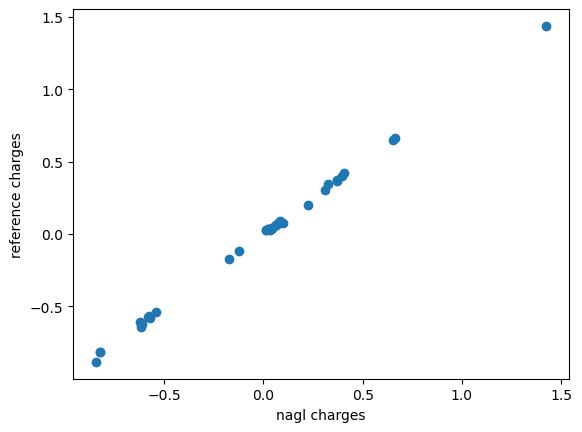

In [15]:
from matplotlib import pyplot

pyplot.scatter(nagl_charges.magnitude, reference_charges.magnitude)
pyplot.ylabel("reference charges")
pyplot.xlabel("nagl charges")

Text(0.5, 0, 'atom index')

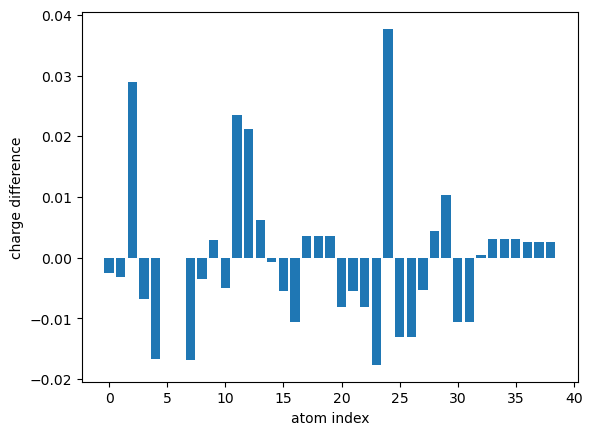

In [16]:
pyplot.bar(range(ncaa_capped.n_atoms), (nagl_charges - reference_charges).magnitude)
pyplot.ylabel("charge difference")
pyplot.xlabel("atom index")

## (Old) Finish making the library charge and run the simulation

In [17]:
ncaa_uncapped_indices = []
for res in ncaa_capped.residues:
    if res.residue_name not in ["ACE", "NME"]:
        ncaa_uncapped_indices += [atom.molecule_atom_index for atom in res.atoms]

In [18]:
formal_charge = 0.0 * unit.elementary_charge
total_partial_charges = 0.0 * unit.elementary_charge

for i in ncaa_uncapped_indices:
    atom = ncaa_capped.atoms[i]
    formal_charge += atom.formal_charge
    total_partial_charges += atom.partial_charge

charge_offset = (formal_charge - total_partial_charges) / len(ncaa_uncapped_indices)
charge_offset

-0.0008542540130282253 <Unit('elementary_charge')>

In [19]:
rdmol = mol_toolkit.Mol(ncaa_capped.to_rdkit())
graph = SingleGraph(rdmol, ncaa_uncapped_indices, layers=1)
charges_smirks = graph.as_smirks()
charges_smirks

'[#7AH1X3x0!r+0:1](-!@[#6AH0X3x0!r+0])(-!@[#1AH0X1x0!r+0:2])-!@[#6AH1X4x0!r+0:3](-!@[#6AH0X3x0!r+0:4](-!@[#7AH1X3x0!r+0])=!@[#8AH0X1x0!r+0:5])(-!@[#6AH1X4x0!r+0:6](-!@[#8AH0X2x0!r+0:8]-!@[#15AH0X4x0!r+0:11](=!@[#8AH0X1x0!r+0:15])(-!@[#8AH0X2x0!r+0:16]-!@[#6AH2X4x0!r+0:18](-!@[#7AH1X3x0!r+0:19](-!@[#6AH2X4x0!r+0:22](-!@[#8AH1X2x0!r+0:24]-!@[#1AH0X1x0!r+0:27])(-!@[#1AH0X1x0!r+0:25])-!@[#1AH0X1x0!r+0:26])-!@[#1AH0X1x0!r+0:23])(-!@[#1AH0X1x0!r+0:20])-!@[#1AH0X1x0!r+0:21])-!@[#8AH0X1x0!r-1:17])(-!@[#1AH0X1x0!r+0:9])-!@[#6AH3X4x0!r+0:10](-!@[#1AH0X1x0!r+0:12])(-!@[#1AH0X1x0!r+0:13])-!@[#1AH0X1x0!r+0:14])-!@[#1AH0X1x0!r+0:7]'

In [20]:
# This will be a list of the charges in the residue
charges = [None for i in ncaa_uncapped_indices]

# Chemper's `SingleGraph` class produces smirks index `:1` corresponding to `ncaa_uncapped_indices[0]`,
# so we can iterate over the indices, put the appropriate charge in place, and apply the offset we
# calculated earlier
for smirks_atom_index, molecule_atom_index in enumerate(ncaa_uncapped_indices, start=1):
    charges[smirks_atom_index - 1] = (
        ncaa_capped.partial_charges[molecule_atom_index] + charge_offset
    )

# Make sure we haven't doubly assigned any charges
assert None not in charges

# Delete any charges we might've put in the last time we ran this cell
try:
    del sage_ff14sb["LibraryCharges"].parameters[charges_smirks]
except openff.toolkit.utils.exceptions.ParameterLookupError:
    pass

# Add the new charges to the library with the ChemPer SMIRKS
sage_ff14sb["LibraryCharges"].add_parameter(
    {"smirks": charges_smirks, "charge": charges}
)

In [21]:
#topology = mol.to_topology()
#topology.box_vectors = np.array([40, 40, 40]) * unit.angstrom

In [22]:
system = sage_ff14sb.create_openmm_system(top)

In [23]:
# Construct and configure a Langevin integrator at 300 K with an appropriate friction constant and time-step
integrator = openmm.LangevinIntegrator(
    300 * omm_unit.kelvin, 1 / omm_unit.picosecond, 0.002 * omm_unit.picoseconds
)

# Combine the topology, system, integrator and initial positions into a simulation
simulation = openmm.app.Simulation(top.to_openmm(), system, integrator)
# Add half the box vector length to all coords (this is cosmetic, it centers the peptide in the box)
positions = top.get_positions() + (0.5 * top.box_vectors.diagonal())
simulation.context.setPositions(positions.to_openmm())

# Add a reporter to record the structure every 50 steps (0.1 ps)
dcd_reporter = DCDReporter("trajectory.dcd", 50)
simulation.reporters.append(dcd_reporter)

In [24]:
simulation.minimizeEnergy()
minimized_state = simulation.context.getState(
    getPositions=True, getEnergy=True, getForces=True
)

print(
    "Minimised to",
    minimized_state.getPotentialEnergy(),
    "with maximum force",
    max(
        np.sqrt(v.x * v.x + v.y * v.y + v.z * v.z) for v in minimized_state.getForces()
    ),
    minimized_state.getForces().unit.get_symbol(),
)

minimized_coords = minimized_state.getPositions()

Minimised to -30059.220092640142 kJ/mol with maximum force 2249.53587761811 kJ/(nm mol)


In [25]:
simulation.context.setVelocitiesToTemperature(simulation.integrator.getTemperature())
simulation.runForClockTime(15 * omm_unit.second)
print(
    f"Completed simulation time: {simulation.integrator.getStepSize() * simulation.currentStep}"
)

Completed simulation time: 7.92 ps


In [26]:
mdt_traj = mdtraj.load(
    "trajectory.dcd", top=mdtraj.Topology.from_openmm(top.to_openmm())
)
mdt_traj.image_molecules(anchor_molecules=[mdt_traj.topology.atoms], inplace=True)

print(mdt_traj)
view = nglview.show_mdtraj(mdt_traj)

view.clear_representations()
view.add_licorice(radius=0.1)
view

<mdtraj.Trajectory with 79 frames, 1766 atoms, 580 residues, and unitcells>


NGLWidget(max_frame=78)

## (New) Appendix: NAGL can quickly assign AM1BCC charges to even large-ish druglike molecules
NAGL scales well with molecule size. 

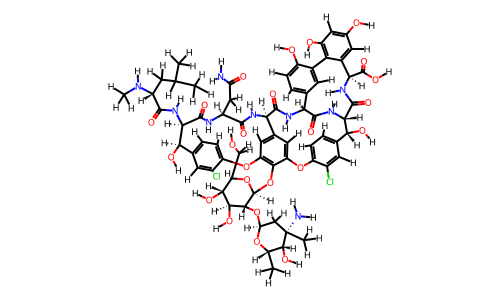

In [27]:
vancomycin = Molecule.from_smiles(
    "C[C@H]1[C@H]([C@@](C[C@@H](O1)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2OC3=C4C=C5C=C3OC6=C(C=C(C=C6)[C@H]([C@H](C(=O)N[C@H](C(=O)N[C@H]5C(=O)N[C@@H]7C8=CC(=C(C=C8)O)C9=C(C=C(C=C9O)O)[C@H](NC(=O)[C@H]([C@@H](C1=CC(=C(O4)C=C1)Cl)O)NC7=O)C(=O)O)CC(=O)N)NC(=O)[C@@H](CC(C)C)NC)O)Cl)CO)O)O)(C)N)O"
)
vancomycin

In [28]:
%%time
vancomycin.assign_partial_charges(
    "_nagl_am1bccelf10", toolkit_registry=_NAGLToolkitWrapper()
)
vancomycin.partial_charges

CPU times: user 8.77 s, sys: 2.1 s, total: 10.9 s
Wall time: 1.58 s


Magnitude,[-0.10233914574862203 0.13390593508004464 0.061420033664696595 0.11346128860234538 0.05476425492882051 0.18017559030770577 -0.12336714288473806 0.338227602632039 0.05019732841967859 -0.4233061047482558 -0.39912885150194843 0.09976282248019495 0.08680564442395487 0.1102518019986085 0.07315396794795313 0.09564321765422144 0.07130805680274287 0.11744512894868174 0.0743817789268426 -0.41167491397143086 0.3239567009520463 0.09354187825440684 -0.30418979844332417 0.07203763255595484 0.09447478035210886 -0.15318900069475852 -0.08265715560198507 -0.15318900069475852 0.09447478035210886 -0.23190140446902 0.09030179956673899 0.01079642304896631 -0.10433124473572454 -0.1285557719159194 -0.10337587168694219 -0.1310287090230056 0.18389511385678567 0.06060893738388338 0.04825020858763971 0.10227668562650004 0.6693878797602586 -0.6223721476483413 -0.5531064244198867 0.05210014709948816 0.11510923782109538 0.6451480416369371 -0.6227138014721938 -0.5422655316281386 0.08842724093913355 0.09679535308598795 0.6502260593485765 -0.6194713087964125 -0.5423433752942153 0.09803551712750712 0.09635968783616343 -0.1377384336876937 -0.06573404839516363 -0.042743918507105925 0.166463914306157 -0.22213959416628562 -0.06098790189505301 -0.4838445754933425 -0.040519525318152526 -0.03958815058947287 -0.17480185350657187 0.17419836202382363 -0.29470079859972675 0.18239584842442788 -0.4869686635422774 -0.4859166117596694 0.09922824332236567 0.13444586375474252 -0.5552414627957412 0.6530762342524461 -0.6092776032376357 0.04497484395026483 0.10283763983964243 0.18326899686574258 0.060771125347607514 -0.1279142173218795 -0.10433124473572454 0.01079642304896631 0.09030179956673899 -0.23190140446902 -0.13102864941836082 -0.1033758642363616 -0.0603758665013381 -0.5892828079152175 -0.5446622939992019 0.6533612040591172 -0.6149412365841933 0.6260701445650987 -0.5495083304333754 -0.5920621725010939 -0.1619049580979415 0.664055171401494 -0.6049977513241835 -0.673152920811183 -0.5588795514988967 0.671644750030034 -0.5895994277882644 0.1266903457951478 0.04559895673512735 -0.08194920143366537 -0.06362416317940435 -0.09017921706915578 -0.09017924687147817 -0.8188154073643752 0.15361498573540963 -0.5894472571301528 -0.0603758665013381 0.1332588819575242 -0.5969508262562819 -0.590028104393489 -0.590027031509883 -0.10824367126703939 -0.9000592800068923 -0.5835664840626784 0.05295318642377176 0.05295319387435236 0.05295318642377176 0.07290862777947703 0.07290865013121882 0.15742051878690042 0.1574205783915452 0.15467888394116677 0.14519726017236032 0.15645844021558084 0.33366877117871563 0.3386562494349412 0.3338061300826005 0.14992161372422494 0.14414266029118813 0.15032121816396035 0.4237175313544206 0.1593303410124711 0.15134041288613595 0.4247338203501634 0.4263199595522813 0.3326598433566026 0.15467888394116677 0.15645844021558084 0.14519726017236032 0.40907550135373394 0.33574033060788433 0.44805607476949016 0.08328549096106806 0.08328548351048747 0.3164760498118333 0.3164760498118333 0.3328211037230424 0.05349675470709123 0.05349673980593004 0.055963586063378236 0.03788607844828882 0.037886063547127626 0.03788607844828882 0.037886063547127626 0.03788607844828882 0.037886063547127626 0.3808429864954881 0.03846203813075342 0.03846201205372133 0.03846203813075342 0.40907547155141155 0.04908360073088922 0.04908360818146982 0.40802917161702434 0.4173487452578477 0.4188962308478288 0.04907350519418039 0.0490734828424386 0.04907350519418039 0.35771951356648723 0.35771951356648723 0.40521133223294536]
Units,elementary_charge


In [29]:
%%time
# This will request AM1BCC ELF10 charges from OpenEye.
# I let it run for ~10 minutes and it didn't finish, but feel free to try yourself.
# vancomycin.assign_partial_charges('am1bccelf10')

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 4.05 µs


An easy way to test NAGL performance with varying molecule size is to throw random proteins at it. 

NVDMLMWCCWDVNWVHYNSS


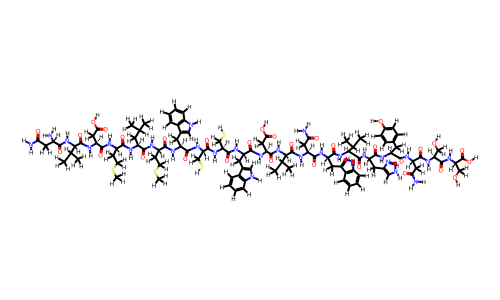

In [30]:
from openff.toolkit import Molecule
from openff.toolkit.utils._nagl_wrapper import _NAGLToolkitWrapper

from rdkit import Chem
import random

amino_acids = "ACDEFGHIKLMNPQSTVWY"  # R causes lots of trouble with stereo
random_sequence = "".join([random.choice(amino_acids) for _ in range(20)])
print(random_sequence)
rand_protein_rdmol = Chem.MolFromFASTA(random_sequence)
Chem.SanitizeMol(rand_protein_rdmol)
Chem.Kekulize(rand_protein_rdmol)

rand_protein = Molecule.from_rdkit(rand_protein_rdmol)
rand_protein

In [31]:
%%time
rand_protein.assign_partial_charges(
    "_nagl_am1bccelf10", toolkit_registry=_NAGLToolkitWrapper()
)
rand_protein.partial_charges

CPU times: user 21 s, sys: 4.72 s, total: 25.8 s
Wall time: 4.9 s


array([-0.8986023 ,  0.11372181,  0.64420742, -0.62063824, -0.170156  ,
        0.65972973, -0.61083739, -0.67430078, -0.54680692,  0.05021058,
        0.65940619, -0.6172741 , -0.07609319, -0.09373058, -0.09373063,
       -0.56119102,  0.04215576,  0.64259619, -0.6225146 , -0.14289048,
        0.63979668, -0.54242539, -0.6080749 , -0.55059963,  0.04547553,
        0.68294651, -0.64656299, -0.08208133, -0.01987359, -0.2883369 ,
       -0.04067972, -0.54894816,  0.04807914,  0.67852933, -0.63791107,
       -0.09030617, -0.06466407, -0.09249868, -0.09249871, -0.55308145,
        0.04721561,  0.68249596, -0.63953423, -0.08218647, -0.01987359,
       -0.2883369 , -0.04067972, -0.54750811,  0.0429302 ,  0.65391315,
       -0.6178531 , -0.02105443, -0.14628684,  0.0177673 , -0.08442536,
       -0.57793313,  0.08176013, -0.08792791, -0.1432121 , -0.15462758,
       -0.11077421, -0.55035763,  0.04489461,  0.65268827, -0.61215746,
       -0.01343718, -0.36952602, -0.54523098,  0.04142086,  0.65140624,
       -0.61367821, -0.01293959, -0.36952602, -0.54419123,  0.04037704,
        0.66559071, -0.62333351, -0.02030013, -0.14628684,  0.0177673 ,
       -0.08442536, -0.57793313,  0.08176013, -0.08792791, -0.1432121 ,
       -0.15462758, -0.11077421, -0.55846202,  0.04155543,  0.64264554,
       -0.62214731, -0.14214937,  0.63979668, -0.54242539, -0.6080749 ,
       -0.54375111,  0.04732011,  0.66201997, -0.62213671, -0.0759811 ,
       -0.09373063, -0.09373058, -0.55666327,  0.0490238 ,  0.64640833,
       -0.61999785, -0.16229036,  0.66305036, -0.60621636, -0.67419397,
       -0.54867034,  0.03897593,  0.65406848, -0.62671202, -0.02042245,
       -0.14628681,  0.01776728, -0.08442536, -0.57793325,  0.08176011,
       -0.08792788, -0.14321212, -0.15462752, -0.11077415, -0.54934483,
        0.0485551 ,  0.66083724, -0.62093126, -0.07649707, -0.09373058,
       -0.09373063, -0.55162274,  0.0439353 ,  0.66409809, -0.62815517,
       -0.1129493 ,  0.29097868, -0.6530835 , -0.24068847,  0.38700432,
       -0.3168196 , -0.55053549,  0.04228127,  0.65598596, -0.62129843,
       -0.03899915, -0.12148414, -0.0834295 , -0.08342946, -0.18360441,
       -0.18360441,  0.13138277, -0.49285355, -0.55559617,  0.05066456,
        0.64648617, -0.61913561, -0.1624506 ,  0.6630503 , -0.60621636,
       -0.67419397, -0.54968708,  0.03470659,  0.64851171, -0.61044436,
        0.1213602 , -0.59600996, -0.56300389,  0.06281017,  0.62216646,
       -0.557814  ,  0.1148688 , -0.59413218, -0.58483791,  0.36829901,
        0.36829904,  0.09608178,  0.07762848,  0.0776285 ,  0.31464548,
        0.31464545,  0.33802862,  0.08888915,  0.064192  ,  0.042321  ,
        0.04232098,  0.042321  ,  0.04232098,  0.042321  ,  0.04232098,
        0.32969517,  0.11402846,  0.1014668 ,  0.1014668 ,  0.44712029,
        0.33886499,  0.09134782,  0.07111356,  0.0711136 ,  0.06879085,
        0.06879084,  0.0639117 ,  0.06391172,  0.0639117 ,  0.33766452,
        0.09109537,  0.0623765 ,  0.06237648,  0.05242388,  0.03830139,
        0.03830141,  0.03830139,  0.03830141,  0.03830139,  0.03830141,
        0.33695561,  0.0919713 ,  0.07111356,  0.0711136 ,  0.06879085,
        0.06879084,  0.0639117 ,  0.06391172,  0.0639117 ,  0.33264358,
        0.09894463,  0.06787445,  0.06787444,  0.17005701,  0.45436937,
        0.13646568,  0.13484909,  0.13360257,  0.13521508,  0.33762629,
        0.10421327,  0.08178689,  0.08178689,  0.20137203,  0.33725721,
        0.10393169,  0.08178689,  0.08178689,  0.201372  ,  0.33430529,
        0.09850953,  0.06787445,  0.06787444,  0.17005701,  0.45436937,
        0.13646568,  0.13484909,  0.13360257,  0.13521508,  0.33404631,
        0.113661  ,  0.1014668 ,  0.1014668 ,  0.44712029,  0.33894245,
        0.08885086,  0.064192  ,  0.042321  ,  0.04232098,  0.042321  ,
        0.04232098,  0.042321  ,  0.04232098,  0.32759047,  0.11567949,
        0.082441  ,  0.082441  ,  0.31571484,  0.31571484,  0.33529843,
        0.09846667,  0.06787445,  0.0678